In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [34]:
# Выгрузка файлов с локального компьютера

df_behavior = pd.read_csv('behavior.csv', sep=';')
df_behavior_old = pd.read_csv('behavior_old.csv', sep=';')
df_fb = pd.read_csv('feedback.csv', sep=';')
df_ulfin = pd.read_csv('ulfin.csv', sep=';')

In [3]:
# Приводим дату к формату date_time

df_behavior['BeginDate'] = pd.to_datetime(df_behavior['BeginDate'], yearfirst=True)
df_behavior['EndDate'] = pd.to_datetime(df_behavior['EndDate'], yearfirst=True)

df_behavior_old['BeginDate'] = pd.to_datetime(df_behavior_old['BeginDate'], yearfirst=True)
df_behavior_old['EndDate'] = pd.to_datetime(df_behavior_old['EndDate'], yearfirst=True)

df_behavior_old['interval'] = df_behavior_old['EndDate'] - df_behavior_old['BeginDate']
df_behavior_old['interval'] = df_behavior_old['interval'] / pd.to_timedelta(1, unit='D')

In [4]:
# Вычисляем сумму усредненных показателей для каждого типа действия и добавляем информацию как поведение агентов

tmp_lst = ['UID', 'nCount', 'Amount', 'Volume', 'Weight']
tmp_dataset = df_behavior_old[df_behavior_old['Action'] == 'Получает в'][tmp_lst].groupby('UID').sum()
tmp_dict = {'nCount' : 'get_in_nCount', 
            'Amount' : 'get_in_Amount', 
            'Volume' : 'get_in_Volume', 
            'Weight' : 'get_in_Weight'}

tmp_dataset.rename(columns=tmp_dict, inplace=True)

df_fb_mod = pd.merge(df_fb, tmp_dataset, on='UID', how='left')

tmp_dataset = df_behavior_old[df_behavior_old['Action'] == 'Получает из'][tmp_lst].groupby('UID').sum()
tmp_dict = {'nCount' : 'get_from_nCount', 
            'Amount' : 'get_from_Amount', 
            'Volume' : 'get_from_Volume', 
            'Weight' : 'get_from_Weight'}

tmp_dataset.rename(columns=tmp_dict, inplace=True)

df_fb_mod = pd.merge(df_fb_mod, tmp_dataset, on='UID', how='left')

tmp_dataset = df_behavior_old[df_behavior_old['Action'] == 'Отправляет из'][tmp_lst].groupby('UID').sum()
tmp_dict = {'nCount' : 'send_from_nCount', 
            'Amount' : 'send_from_Amount', 
            'Volume' : 'send_from_Volume', 
            'Weight' : 'send_from_Weight'}

tmp_dataset.rename(columns=tmp_dict, inplace=True)

df_fb_mod = pd.merge(df_fb_mod, tmp_dataset, on='UID', how='left')


tmp_dataset = df_behavior_old[df_behavior_old['Action'] == 'Отправляет из'][tmp_lst].groupby('UID').sum()
tmp_dict = {'nCount' : 'send_in_nCount', 
            'Amount' : 'send_in_Amount', 
            'Volume' : 'send_in_Volume', 
            'Weight' : 'send_in_Weight'}

tmp_dataset.rename(columns=tmp_dict, inplace=True)

df_fb_mod = pd.merge(df_fb_mod, tmp_dataset, on='UID', how='left')

tmp_dataset = df_behavior_old[df_behavior_old['Action'] == 'Платит за услуги'][['UID', 'Caption']].groupby('UID').count()
tmp_dict = {'Caption' : 'n_service'}
tmp_dataset.rename(columns=tmp_dict, inplace=True)

df_fb_mod = pd.merge(df_fb_mod, tmp_dataset, on='UID', how='left')

tmp_dataset = df_behavior_old[df_behavior_old['Action'] == 'Платит за услуги'][['UID', 'Amount']].groupby('UID').sum()
tmp_dict = {'Amount' : 'sum_amount_service'}
tmp_dataset.rename(columns=tmp_dict, inplace=True)

df_fb_mod = pd.merge(df_fb_mod, tmp_dataset, on='UID', how='left')

tmp_dataset = df_behavior_old[df_behavior_old['Action'] == 'Обращание в поддержку'][['UID', 'Caption']].groupby('UID').count()
tmp_dict = {'Caption' : 'n_support'}
tmp_dataset.rename(columns=tmp_dict, inplace=True)

df_fb_mod = pd.merge(df_fb_mod, tmp_dataset, on='UID', how='left')

tmp_dataset = df_behavior_old[df_behavior_old['Action'] == 'Обращание в поддержку'][['UID', 'Amount']].groupby('UID').mean()
tmp_dict = {'Amount' : 'avg_day_support'}
tmp_dataset.rename(columns=tmp_dict, inplace=True)

df_fb_mod = pd.merge(df_fb_mod, tmp_dataset, on='UID', how='left')

# Средний интервал дней сотрудничества

tmp_dataset = df_behavior_old[['UID', 'interval']].groupby('UID').mean()

df_fb_mod = pd.merge(df_fb_mod, tmp_dataset, on='UID', how='left')

# Добавляем также тип агента и его ОКВЭД

df_fb_mod = pd.merge(df_fb_mod, df_behavior_old[['UID', 'UnitType', 'OKVED']].drop_duplicates(), on='UID', how='left')

# Прикрутим столбец с количеством оптравленных писем всего

df_fb_mod['count_emails'] = df_fb_mod['nClick'] + df_fb_mod['nOpen'] + df_fb_mod['nSend']

Всего агентов, не совершивших клик: 7864, что составляет 78.64% от общего числа
Всего агентов, совершивших клик: 2136 что составляет 21.36% от общего числа


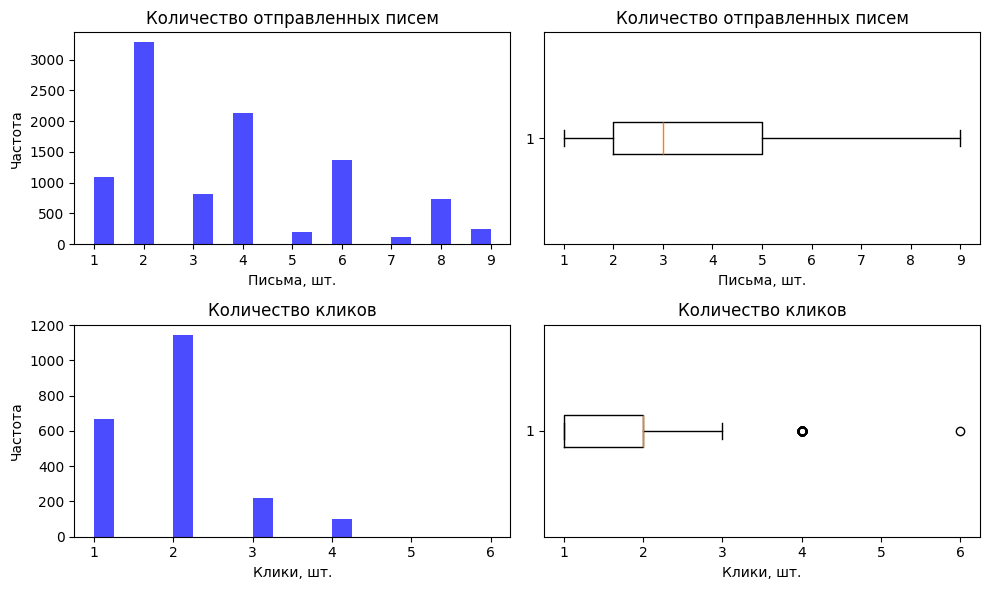

In [5]:
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
plt.hist(df_fb_mod['count_emails'], bins=20, color='blue', alpha=0.7)
plt.xlabel('Письма, шт.')
plt.ylabel('Частота')
plt.title('Количество отправленных писем')

plt.subplot(2, 2, 2)
plt.boxplot(df_fb_mod['count_emails'], vert=False)
plt.xlabel('Письма, шт.')
plt.title('Количество отправленных писем')

plt.subplot(2, 2, 3)
plt.hist(df_fb_mod[df_fb_mod['nClick'] != 0]['nClick'], bins=20, color='blue', alpha=0.7)
plt.xlabel('Клики, шт.')
plt.ylabel('Частота')
plt.title('Количество кликов')

plt.subplot(2, 2, 4)
plt.boxplot(df_fb_mod[df_fb_mod['nClick'] != 0]['nClick'], vert=False)
plt.xlabel('Клики, шт.')
plt.title('Количество кликов')

var_1 = df_fb_mod[df_fb_mod['nClick'] == 0]['nClick'].value_counts().sum()
var_2 = df_fb_mod[df_fb_mod['nClick'] != 0]['nClick'].value_counts().sum()

print(f'Всего агентов, не совершивших клик: {var_1}, что составляет {var_1 / 10000 * 100}% от общего числа')
print(f'Всего агентов, совершивших клик: {var_2} что составляет {var_2 / 10000 * 100}% от общего числа')

plt.tight_layout()
plt.show()

Выводы:

1. Всего представлено 10000 агентов, среди них в среднем каждому агенту было отправлено по 3 письма. 75% агентов получают до 5 писем. Есть некоторая доля агенто, получающих до 9 писем.

2. Не кликают по ссылке из письма 78.6% от общего числа агентов. Среди откликнувшихся, в среднем каждый агент откликается на 2 письма из всех полученных. 75% процентов откликаются на 3 письма из полученных. Макисмально доступное число кликов - 6, встречается в одном случае.

Целевая переменная - клик. Посмотрим подробнеее взаимосвязи.

In [6]:
# Берем откликнувшихся более, чем один раз

df_fb_mod_good_click = df_fb_mod[df_fb_mod['nClick'] > 2]

# Статистика в разбивке по типу агента 

var_1 = df_fb_mod_good_click.shape[0]
var_2 = df_fb_mod_good_click['UnitType'].value_counts()['Юридическое лицо']
var_3 = df_fb_mod_good_click['UnitType'].value_counts()['Физическое лицо']
var_4 = df_fb_mod_good_click['UnitType'].value_counts()['Индивидуальный предприниматель']

print('Статистика откликнувшихся на 3 и более писем \n')
print(f'Всего откликнувшихся больше 3 раз: {var_1} \n')
print(f'1. Из них юридических лиц: {var_2}, что составляет {round(var_2 / var_1 * 100, 2)}% от всего числа')
print(f'2. Из них физических лиц: {var_3}, что составляет {round(var_3 / var_1 * 100, 2)}% от всего числа')
print(f'3. Из них ИП: {var_4}, что составляет {round(var_4 / var_1 * 100, 2)}% от всего числа')

Статистика откликнувшихся на 3 и более писем 

Всего откликнувшихся больше 3 раз: 323 

1. Из них юридических лиц: 191, что составляет 59.13% от всего числа
2. Из них физических лиц: 24, что составляет 7.43% от всего числа
3. Из них ИП: 63, что составляет 19.5% от всего числа


In [7]:
# Берем не откликнувшихся агентов

df_fb_mod_not_click = df_fb_mod[df_fb_mod['nClick'] == 0]

# Статистика в разбивке по типу агента 

var_1 = df_fb_mod_not_click.shape[0]
var_2 = df_fb_mod_not_click['UnitType'].value_counts()['Юридическое лицо']
var_3 = df_fb_mod_not_click['UnitType'].value_counts()['Физическое лицо']
var_4 = df_fb_mod_not_click['UnitType'].value_counts()['Индивидуальный предприниматель']

print('Статистика не откликнувшихся ни разу на письма \n')
print(f'Всего не откликнувшихся: {var_1} \n')
print(f'1. Из них юридических лиц: {var_2}, что составляет {round(var_2 / var_1 * 100, 2)}% от всего числа')
print(f'2. Из них физических лиц: {var_3}, что составляет {round(var_3 / var_1 * 100, 2)}% от всего числа')
print(f'3. Из них ИП: {var_4}, что составляет {round(var_4 / var_1 * 100, 2)}% от всего числа')

Статистика не откликнувшихся ни разу на письма 

Всего не откликнувшихся: 7864 

1. Из них юридических лиц: 2710, что составляет 34.46% от всего числа
2. Из них физических лиц: 845, что составляет 10.75% от всего числа
3. Из них ИП: 992, что составляет 12.61% от всего числа


Соотношение хорошо откликающихся и не откликающихся агентов сохраняется, что может объясняться их изначальными весами в исходном распределении.

In [8]:
# Проверим, какие переменные больше всего коррелируют с откликом

df_fb_corr = df_fb_mod[df_fb_mod['nClick'] > 0].drop(['UID', 'UnitType', 'nSend'], axis=1).corr()
df_fb_corr['nClick'].sort_values()

OKVED                -0.092025
send_from_Amount     -0.033693
send_in_Amount       -0.033693
get_from_Amount      -0.033693
send_in_Volume        0.016415
get_from_Volume       0.016415
send_from_Volume      0.016415
get_from_Weight       0.028146
send_from_Weight      0.028146
send_in_Weight        0.028146
sum_amount_service    0.030411
get_in_Amount         0.036247
avg_day_support       0.050294
get_in_Weight         0.102240
get_in_Volume         0.130586
send_from_nCount      0.136174
send_in_nCount        0.136174
get_in_nCount         0.136174
get_from_nCount       0.136174
interval              0.160241
n_service             0.199139
n_support             0.239476
nOpen                 0.295123
count_emails          0.632011
nClick                1.000000
Name: nClick, dtype: float64

Выводы.

Корреляция с приведенными признаками достаточно слабая, однако можно выделить наиболее выдающиеся показатели.

1. Чем выше число обращений клиента в службу поддержки, тем выше вероятность его эффективной кликабельности.
2. Чем выше среднее взаимодействие агента с компанией в днях (лояльность), тем выше вероятность, что он более кликабелен.
3. Чем выше количество услуг на получение из/в и отправку из/в, тем выше вероятность кликабельности агента.
4. Чем больше дополнительных услуг приобретает клиент у компании, тем выше вероятность того, что он более кликабелен.

In [9]:
# Посмотрим на статистические параметры коррелирующих с откликом переменных

tmp_lst = ['send_from_nCount', 'send_in_nCount', 'get_in_nCount', 'get_from_nCount', 'n_support', 'n_service', 'count_emails', 'interval']
df_fb_mod[df_fb_mod['nClick'] > 0][tmp_lst].describe().round(2)

,send_from_nCount,send_in_nCount,get_in_nCount,get_from_nCount,n_support,n_service,count_emails,interval
count,623.00,623.00,623.00,623.00,846.00,1019.00,2136.00,1424.00
mean,39.14,39.14,39.14,39.14,1.25,5.69,4.92,86.58
std,151.31,151.31,151.31,151.31,0.43,2.59,1.97,85.11
min,1.00,1.00,1.00,1.00,1.00,1.00,2.00,0.00
25%,1.00,1.00,1.00,1.00,1.00,4.00,4.00,0.38
50%,3.00,3.00,3.00,3.00,1.00,5.00,4.00,72.08
75%,17.00,17.00,17.00,17.00,2.00,7.00,6.00,145.20
max,2195.00,2195.00,2195.00,2195.00,2.00,19.00,9.00,356.00


Выводы.

1. Для кликабельных агентов, отправляющих в/из среднее число заказов составляет 39 штук.
2. Для кликабельных агентов, получающих в/из среднее число заказов составляет также 39 штук.
3. В среднем кликабельные агенты обращуются 1-2 раза в поддержку.
4. В среднем кликабельные агенты получают около 5 писем, 75% агентов получило до 6 писем. 
5. Среднее число услуг, приобретаемое кликабельными агентами, варьируется от 5 до 6.
6. В среднем кликабельные агенты взаимодействуют с компанией 86-87 дней. Однако встречаются и лояльные клиенты, которые почти год пользщуются услугами ПЭК.

In [10]:
# Проверим, каким ОКВЭДам соответствуют наиболее откликающиеся агенты (от 3 кликов)

df_okved = pd.read_excel('okved2.xlsx')

def replace_oved_elem(element):
    try:
        element = int(element)
        element = str(element)
    except:
        element = str(element)
        
    return element

df_fb_mod_good_click['OKVED'] = df_fb_mod_good_click['OKVED'].apply(replace_oved_elem)
tmp_df = pd.merge(df_fb_mod_good_click, df_okved[['Название', 'kod']], left_on='OKVED', right_on='kod', how='left')

tmp_lst = list(tmp_df[tmp_df['nClick'] > 3]['Название'].value_counts().head(10).index)

C:\Users\HYPERPC\AppData\Local\Temp\ipykernel_30832\2248008887.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fb_mod_good_click['OKVED'] = df_fb_mod_good_click['OKVED'].apply(replace_oved_elem)


In [11]:
print(f'Наиболее откликающиеся юридические лица (от 3 кликов): \n');
for i in range(len(tmp_lst)):
    print(f'{i+1}. {tmp_lst[i]}')

Наиболее откликающиеся юридические лица (от 3 кликов): 

1. Торговля оптовая прочими машинами, приборами, аппаратурой и оборудованием общепромышленного и специального назначения
2. Торговля розничная прочая в неспециализированных магазинах
3. Торговля оптовая санитарно-техническим оборудованием
4. Торговля оптовая молочными продуктами, яйцами и пищевыми маслами и жирами
5. Торговля оптовая эксплуатационными материалами и принадлежностями машин
6. Торговля оптовая лесоматериалами, строительными материалами и санитарно-техническим оборудованием
7. Производство строительных металлических конструкций, изделий и их частей
8. Торговля оптовая автомобильными деталями, узлами и принадлежностями, кроме деятельности агентов
9. Производство мебели
10. Торговля оптовая фармацевтической продукцией


In [12]:
# Проверим, за какими услугами чаще всего обращаются в поддержку откликающиеся агенты

tmp_lst = list(df_fb_mod[df_fb_mod['nClick'] > 0]['UID'].unique())

df_fb_mod_good_click_support = df_behavior_old[df_behavior_old['Action'] == 'Обращание в поддержку']
df_fb_mod_good_click_support = df_fb_mod_good_click_support.loc[df_fb_mod_good_click_support['UID'].isin(tmp_lst)]

var = df_fb_mod_good_click_support['Caption'].value_counts()

print(f'За услугой "{var.index[0]}" обратилось {var.values[0]} агентов.')
print(f'За услугой "{var.index[1]}" обратилось {var.values[1]} агентов.')

За услугой "Консультация и обслуживание" обратилось 616 агентов.
За услугой "Претензия" обратилось 444 агентов.


Таким образом, обращения в поддержку одинаковы в своем соотношении для откликаюшихся агентов.

In [13]:
# Проверим, какие 5 услуг чаще всего приобретают кликающие агенты (из тех, кто в принципе приобретает услуги)

tmp_lst = list(df_fb_mod[df_fb_mod['nClick'] > 0]['UID'].unique())

df_fb_mod_good_click_service = df_behavior_old[df_behavior_old['Action'] == 'Платит за услуги']
df_fb_mod_good_click_service = df_fb_mod_good_click_service.loc[df_fb_mod_good_click_service['UID'].isin(tmp_lst)]

var = df_fb_mod_good_click_service['Caption'].value_counts().head(5)

for i in range(5):
    print(f'{i+1}. За услугой "{var.index[i]}" обратилось {var.values[i]} агентов, что составляет {
        round(var.values[i] / df_fb_mod_good_click_service['UID'].value_counts().sum() * 100, 2)}% от общего числа')

1. За услугой "Перевозка" обратилось 973 агентов, что составляет 16.77% от общего числа
2. За услугой "Страхование" обратилось 962 агентов, что составляет 16.58% от общего числа
3. За услугой "Организация страхования груза" обратилось 871 агентов, что составляет 15.01% от общего числа
4. За услугой "Жесткая упаковка" обратилось 557 агентов, что составляет 9.6% от общего числа
5. За услугой "Доставка" обратилось 462 агентов, что составляет 7.96% от общего числа


---

# UPD  с новыми данными

In [137]:
# В данных были замечены дубликаты, которые необходимо удалить

df_ulfin = df_ulfin.drop_duplicates()
df_ulfin['year'].value_counts()

year
2018    3457
2019    3457
2020    3457
2021    3457
2022    3457
Name: count, dtype: int64

In [50]:
# Изменим столбцы для понимания

tmp_dict = {
    'code_1600' : 'Активы  всего',
    'code_1300' : 'Капитал и резервы',
    'code_1700' : 'Пассивы всего',
    'code_2110' : 'Выручка',
    'code_2100' : 'Валовая прибыль (убыток)',
    'code_2300' : 'Прибыль (убыток) до налогообложения',
    'code_2400' : 'Чистая прибыль (убыток)',
    'code_6200' : 'Всего поступило средств'
}

df_ulfin.rename(columns=tmp_dict, inplace=True)

In [80]:
# Транспонируем исходный датасет, выделим для каждого года отдельный набор столбцов

df_ulfin_years = list(df_ulfin['year'].unique())

df_ulfin_mod = df_ulfin[df_ulfin['year'] == df_ulfin_years[0]].copy()

for element in df_ulfin_years[1:]:
    df_ulfin_mod = pd.merge(df_ulfin_mod, df_ulfin[df_ulfin['year'] == element], how='left', on='UID', suffixes=('', f'_{element}'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3457 entries, 0 to 3456
Data columns (total 46 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   UID                                       3457 non-null   object 
 1   year                                      3457 non-null   int64  
 2   Активы  всего                             2673 non-null   float64
 3   Капитал и резервы                         2666 non-null   float64
 4   Пассивы всего                             2673 non-null   float64
 5   Выручка                                   2579 non-null   float64
 6   Валовая прибыль (убыток)                  1559 non-null   float64
 7   Прибыль (убыток) до налогообложения       2605 non-null   float64
 8   Чистая прибыль (убыток)                   2606 non-null   float64
 9   Всего поступило средств                   25 non-null     float64
 10  year_2019                           

In [86]:
# Объединим информацию об ЮЛ с их конверсией
df_fb_mod_v2 = pd.merge(df_fb, df_ulfin_mod, how='left', on='UID')

# Будем работать только с теми, для кого нашлась информация
df_fb_mod_v2 = df_fb_mod_v2[~df_fb_mod_v2['year'].isnull()]

In [91]:
# Проверим новые признаки на пропущенные значения

df_fb_mod_v2.isnull().sum().sort_values(ascending=False)

Всего поступило средств                     3432
Всего поступило средств_2022                3431
Всего поступило средств_2019                3427
Всего поступило средств_2021                3426
Всего поступило средств_2020                3424
Валовая прибыль (убыток)_2022               1944
Валовая прибыль (убыток)                    1898
Валовая прибыль (убыток)_2021               1895
Валовая прибыль (убыток)_2019               1871
Валовая прибыль (убыток)_2020               1848
Выручка                                      878
Прибыль (убыток) до налогообложения          852
Чистая прибыль (убыток)                      851
Капитал и резервы                            791
Пассивы всего                                784
Активы  всего                                784
Выручка_2019                                 619
Чистая прибыль (убыток)_2019                 593
Прибыль (убыток) до налогообложения_2019     588
Капитал и резервы_2019                       534
Активы  всего_2019  

Так, для графы "Всего поступило средств" имеется множество NULL-объектов, поэтому мы не будем рассматривать зависимости с этими столбцами.

In [136]:
# Проверим, какие переменные больше всего коррелируют с откликом

# Исключим из корреляционного столбца столбцы с пропущенной информацией и ненужной информацией

tmp_lst = ['UID', 'nSend', 'year', 'year_2019', 'year_2020', 'year_2021', 'year_2022', 
           'Всего поступило средств', 'Всего поступило средств_2019', 'Всего поступило средств_2020', 'Всего поступило средств_2021', 'Всего поступило средств_2022']
df_fb_mod_v2_corr = df_fb_mod_v2[df_fb_mod_v2['nClick'] > 0].drop(tmp_lst, axis=1).corr()

df_fb_mod_v2_corr['nClick'].sort_values()

Валовая прибыль (убыток)_2022              -0.109542
Чистая прибыль (убыток)                    -0.101276
Прибыль (убыток) до налогообложения        -0.100914
Валовая прибыль (убыток)_2019              -0.096763
Валовая прибыль (убыток)_2021              -0.089850
Прибыль (убыток) до налогообложения_2019   -0.079644
Чистая прибыль (убыток)_2022               -0.078618
Прибыль (убыток) до налогообложения_2022   -0.077811
Чистая прибыль (убыток)_2019               -0.077770
Валовая прибыль (убыток)_2020              -0.077147
Выручка                                    -0.072995
Выручка_2019                               -0.069155
Выручка_2020                               -0.060392
Активы  всего_2021                         -0.059969
Пассивы всего_2021                         -0.059969
Выручка_2021                               -0.056763
Активы  всего                              -0.055778
Пассивы всего                              -0.055778
Активы  всего_2020                         -0.

Можно заметить, что приведенные признаки достаточно слабо корреелируют с откликов агентов, однако можно рассмотреть Валовую прибыль (убыток) за 2022 год и чистую прибыль (убыток) за 2018 год. Видим коэффициент корреляции около -0.1. То есть, с увеличением данных показателей, снижается эффеективность отклика агентов.

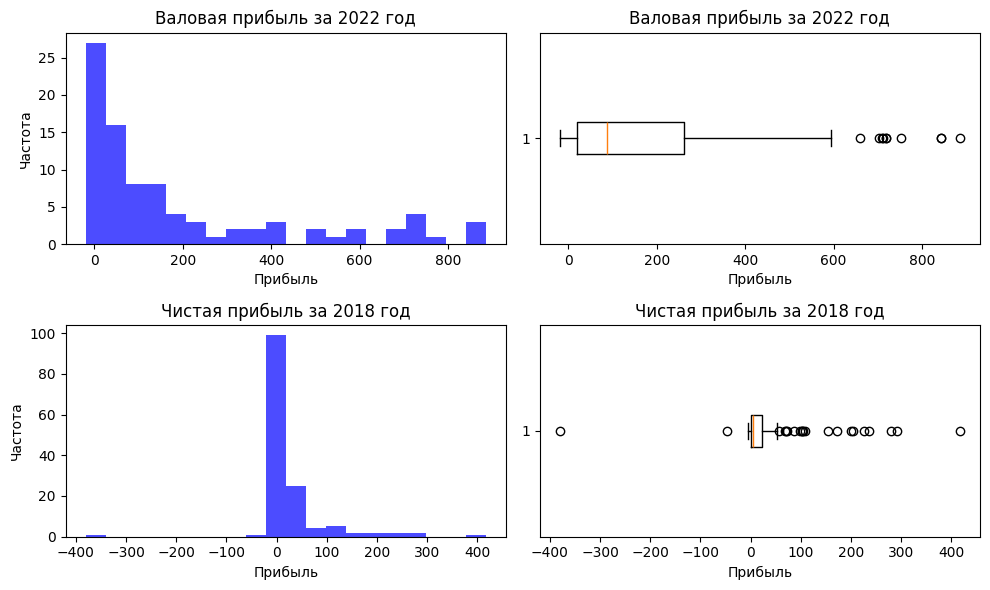

In [140]:
# Проверим распределение данных показателей для кликабельных агентов

plt.figure(figsize=(10, 6))

# В ходе предварительного анализа были замечены выбросы в данных, поэтому была взята граница < 1000 для валовой прибыли за 2022 год

plt.subplot(2, 2, 1)
plt.hist(df_fb_mod_v2[(df_fb_mod_v2['nClick'] > 2) & (df_fb_mod_v2['Валовая прибыль (убыток)_2022'] < 1000)]['Валовая прибыль (убыток)_2022'], bins=20, color='blue', alpha=0.7)
plt.xlabel('Прибыль')
plt.ylabel('Частота')
plt.title('Валовая прибыль за 2022 год')

plt.subplot(2, 2, 2)
plt.boxplot(df_fb_mod_v2[(df_fb_mod_v2['nClick'] > 2) & (df_fb_mod_v2['Валовая прибыль (убыток)_2022'] < 1000)]['Валовая прибыль (убыток)_2022'], vert=False)
plt.xlabel('Прибыль')
plt.title('Валовая прибыль за 2022 год')


# В ходе предварительного анализа были замечены выбросы в данных, поэтому была взята граница < 700 для чистой прибыли за 2018 год

plt.subplot(2, 2, 3)
plt.hist(df_fb_mod_v2[(df_fb_mod_v2['nClick'] > 2) & (df_fb_mod_v2['Чистая прибыль (убыток)'] < 700)]['Чистая прибыль (убыток)'], bins=20, color='blue', alpha=0.7)
plt.xlabel('Прибыль')
plt.ylabel('Частота')
plt.title('Чистая прибыль за 2018 год')

plt.subplot(2, 2, 4)
plt.boxplot(df_fb_mod_v2[(df_fb_mod_v2['nClick'] > 2) & (df_fb_mod_v2['Чистая прибыль (убыток)'] < 700)]['Чистая прибыль (убыток)'], vert=False)
plt.xlabel('Прибыль')
plt.title('Чистая прибыль за 2018 год')

plt.tight_layout()
plt.show()

Выводы.

1. Подавляющее большинство кликабельных агентов получает до 250 валовой прибыли (75%) в 2022 году. В среднем валовая прибыль в 2022 году для таких агентов составляет 100 единиц.
2. Подавляющее большинство кликабельных агентов практически не получает отрицательной чистой прибыли в 2018 году, но и не получает ее слишком много в сравнении с менее кликабельными агентами. Среднее число варьируется около 10.

# Выводы. Сводка

## Количество отправленных и клик

1. Всего агентов, не совершивших клик: 7864, что составляет 78.64% от общего числа
2. Всего агентов, совершивших клик: 2136 что составляет 21.36% от общего числа
3. Всего представлено 10000 агентов, среди них в среднем каждому агенту было отправлено по 3 письма. 75% агентов получают до 5 писем. Есть некоторая доля агенто, получающих до 9 писем.
4. Не кликают по ссылке из письма 78.6% от общего числа агентов. Среди откликнувшихся, в среднем каждый агент откликается на 2 письма из всех полученных. 75% процентов откликаются на 3 письма из полученных. Макисмально доступное число кликов - 6, встречается в одном случае.

## Отклик

Всего откликнувшихся больше 3 раз: 323 

1. Из них юридических лиц: 191, что составляет 59.13% от всего числа
2. Из них физических лиц: 24, что составляет 7.43% от всего числа
3. Из них ИП: 63, что составляет 19.5% от всего числа

Всего не откликнувшихся: 7864 

1. Из них юридических лиц: 2710, что составляет 34.46% от всего числа
2. Из них физических лиц: 845, что составляет 10.75% от всего числа
3. Из них ИП: 992, что составляет 12.61% от всего числа

Соотношение хорошо откликающихся и не откликающихся агентов сохраняется, что может объясняться их изначальными весами в исходном распределении.

## Корреляция с кликом 

1. Чем выше число обращений клиента в службу поддержки, тем выше вероятность его эффективной кликабельности.
2. Чем выше среднее взаимодействие агента с компанией в днях (лояльность), тем выше вероятность, что он более кликабелен.
3. Чем выше количество услуг на получение из/в и отправку из/в, тем выше вероятность кликабельности агента.
4. Чем больше дополнительных услуг приобретает клиент у компании, тем выше вероятность того, что он более кликабелен.

Выводы по корреляционным переменным (статистические параметры) следующие.

1. Для кликабельных агентов, отправляющих в/из среднее число заказов составляет 39 штук.
2. Для кликабельных агентов, получающих в/из среднее число заказов составляет также 39 штук.
3. В среднем кликабельные агенты обращуются 1-2 раза в поддержку.
4. В среднем кликабельные агенты получают около 5 писем, 75% агентов получило до 6 писем. 
5. Среднее число услуг, приобретаемое кликабельными агентами, варьируется от 5 до 6.
6. В среднем кликабельные агенты взаимодействуют с компанией 86-87 дней. Однако встречаются и лояльные клиенты, которые почти год пользщуются услугами ПЭК.

## Откликающиеся по ОКВЭД

Наиболее откликающиеся юридические лица (от 3 кликов): 

1. Торговля оптовая прочими машинами, приборами, аппаратурой и оборудованием общепромышленного и специального назначения
2. Торговля розничная прочая в неспециализированных магазинах
3. Торговля оптовая санитарно-техническим оборудованием
4. Торговля оптовая молочными продуктами, яйцами и пищевыми маслами и жирами
5. Торговля оптовая эксплуатационными материалами и принадлежностями машин
6. Торговля оптовая лесоматериалами, строительными материалами и санитарно-техническим оборудованием
7. Производство строительных металлических конструкций, изделий и их частей
8. Торговля оптовая автомобильными деталями, узлами и принадлежностями, кроме деятельности агентов
9. Производство мебели
10. Торговля оптовая фармацевтической продукцией

## Откликающиеся по услугам поддержки

1. За услугой "Консультация и обслуживание" обратилось 616 агентов.
2. За услугой "Претензия" обратилось 444 агентов.

Таким образом, обращения в поддержку одинаковы в своем соотношении для откликаюшихся агентов.

## Откликающиеся по дополнительным услугам

1. За услугой "Перевозка" обратилось 973 агентов, что составляет 16.77% от общего числа
2. За услугой "Страхование" обратилось 962 агентов, что составляет 16.58% от общего числа
3. За услугой "Организация страхования груза" обратилось 871 агентов, что составляет 15.01% от общего числа
4. За услугой "Жесткая упаковка" обратилось 557 агентов, что составляет 9.6% от общего числа
5. За услугой "Доставка" обратилось 462 агентов, что составляет 7.96% от общего числа

---
## UPD
## Откликающиеся по финансовым показателям

1. Можно заметить, что приведенные признаки достаточно слабо корреелируют с откликов агентов, однако можно рассмотреть Валовую прибыль (убыток) за 2022 год и чистую прибыль (убыток) за 2018 год. Видим коэффициент корреляции около -0.1. То есть, с увеличением данных показателей, снижается эффеективность отклика агентов.
2. Подавляющее большинство кликабельных агентов получает до 250 валовой прибыли (75%) в 2022 году. В среднем валовая прибыль в 2022 году для таких агентов составляет 100 единиц.
3. Подавляющее большинство кликабельных агентов практически не получает отрицательной чистой прибыли в 2018 году, но и не получает ее слишком много в сравнении с менее кликабельными агентами. Среднее число варьируется около 10.
